# Convolutional Neural Network - Image Recognition
by Gaetano Bonofiglio, Veronica Iovinella

## Introduction
The previous notebook we implemented a simple *Convolutional Neural Network* with $TensorFlow$ which has a classification accuracy of about 99%. We will now do a similar thing for a different task, **Image Classification** in the CIFAR-10 data-set, also using the Saver included in $TensorFlow$ to avoid losing the NN once the learning has ended. We will also use **PrettyTensor** for faster implementation. 

PrettyTensor will also allow to easily build convolution layers that can be trained to extract better features, instead of the random ones we used in the previous notebooks.

## Flowchart
The following chart shows roughly how the data flows in the Convolutional Neural Network that is implemented below. First the network has a pre-processing layer which distorts the input images so as to artificially inflate the training-set. Then the network has two convolutional layers, two fully-connected layers and finally a softmax classification layer. The weights and outputs of the convolutional layers are shown in more detail in the larger plots near the end of this notebook.

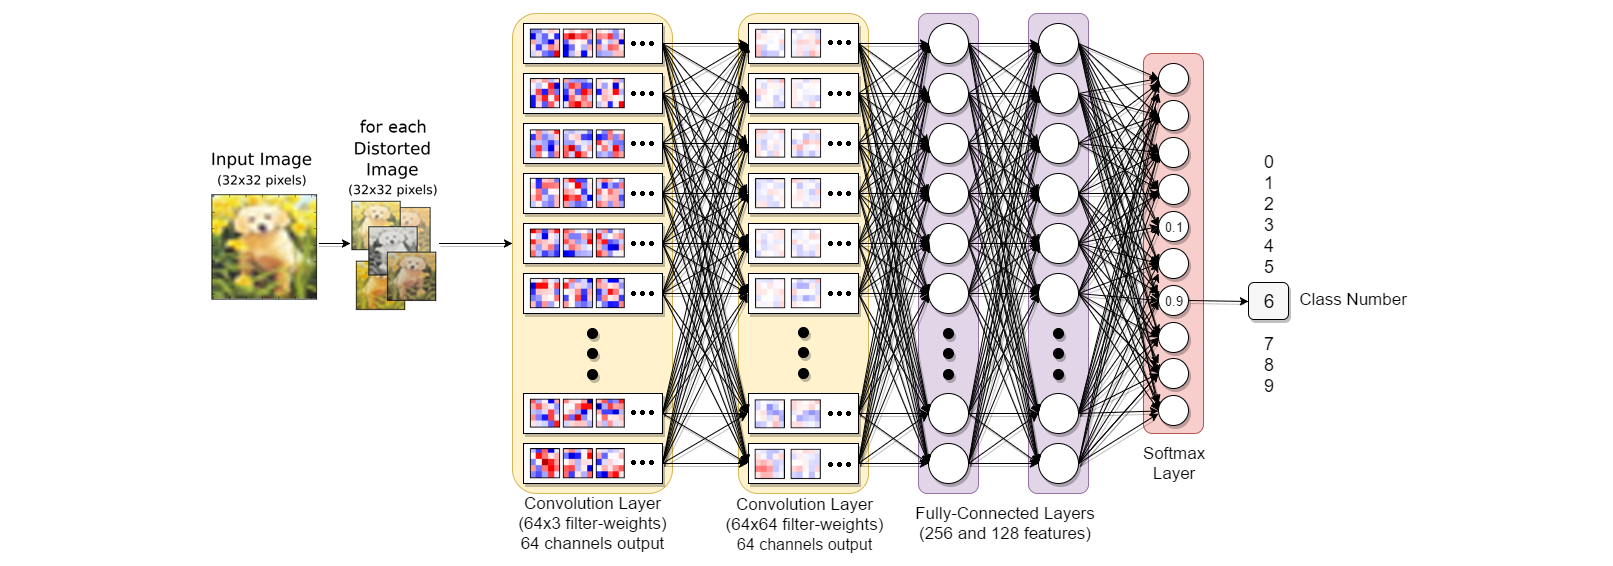

In [1]:
from IPython.display import Image
Image('images/03_flowchart.png')

## Imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import random
import os

from util import Util
u = Util()

# We use PrettyTensor to simplify Neural Network construction.
import prettytensor as pt

tf.__version__

'1.10.0'

## Data Load

In [3]:
import cifar10 as dataset
# Set the path for storing the data-set on your computer.
dataset.data_path = "data/CIFAR-10/"
# The CIFAR-10 data-set is about 163 MB and will be downloaded automatically if it is not located in the given path.
dataset.maybe_download_and_extract()

- Download progress: 100.0%
Download finished. Extracting files.
Done.


### Loading the class-names

In [4]:
class_names = dataset.load_class_names()
class_names

Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

### Loading the training-set
This returns the images, the class-numbers as integers, and the class-numbers as One-Hot encoded arrays called labels.

In [5]:
images_train, cls_train, labels_train = dataset.load_training_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5


### Loading the test set

In [6]:
images_test, cls_test, labels_test = dataset.load_test_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


The CIFAR-10 data-set has now been loaded and consists of 60000 images and associated labels. The data-set is split into 2 mutually exclusive sub-sets, the training-set and the test-set.

In [7]:
print("Size of")
print("- Training-set:\t\t{}".format(len(images_train)))
print("- Test-set:\t\t{}".format(len(images_test)))

Size of
- Training-set:		50000
- Test-set:		10000


### Data Dimensions
The data dimensions are used in several places in the source-code below. They have already been defined in the cifar10 module, so we just need to import them.

In [8]:
from cifar10 import img_size, num_channels, num_classes

The images are 32 x 32 pixels, but can be cropped to later increase the dataset and produce less overfitting, and also for faster computation.

In [9]:
img_size_cropped = 24

### Helper-function for plotting images
Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [10]:
def plot_images(images, cls_true, cls_pred=None, smooth=True): 
    u.plot_images_2(images=images, cls_true=cls_true, class_names=class_names, cls_pred=cls_pred, smooth=smooth)

### Some plotted images from the data set

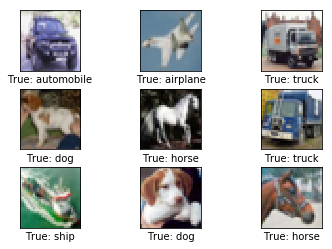

In [11]:
offset = random.randint(0,1000)
# Get the first images from the test-set.
images = images_test[offset:offset+9]

# Get the true classes for those images.
cls_true = cls_test[offset:offset+9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=False)

The pixelated images above (nearest interpolation) are basically what the neural network will get as input. The images might be a bit easier for the human eye to recognize if we smoothen the pixels.

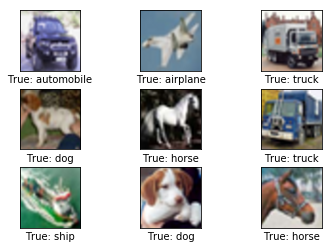

In [12]:
plot_images(images=images, cls_true=cls_true, smooth=True)

## TensorFlow Graph
The structure of the $TensorFlow$ graph is basically the same as the previous notebook, consisting of the following parts:
- Placeholder variables used for inputting data to the graph.
- Variables that are going to be optimized so as to make the convolutional network perform better.
- The mathematical formulas for the convolutional network.
- A cost measure that can be used to guide the optimization of the variables.
- An optimization method which updates the variables.

In addition, the $TensorFlow$ graph may also contain various debugging statements e.g. for logging data to be displayed using *TensorBoard*, that we are not going to use here.

### Placeholder variables
Placeholder variables serve as the input to the $TensorFlow$ computational graph that we may change each time we execute the graph. We call this *feeding* the placeholder variables and it is demonstrated further below.

First we define the placeholder variable for the input images. This allows us to change the images that are input to the $TensorFlow$ graph. This is a so-called *tensor*, which just means that it is a multi-dimensional array. The data-type is set to float32 and the shape is set to [None, img_size, img_size, num_channels], where None means that the tensor may hold an arbitrary number of images with each image being *img_size* pixels high and *img_size* pixels wide and with *num_channels* colour channels.

In [13]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')

Next we have the placeholder variable for the true labels associated with the images that were input in the placeholder variable x. The shape of this placeholder variable is [None, num_classes] which means it may hold an arbitrary number of labels and each label is a vector of length *num_classes* which is 10 in this case.

In [14]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

We could also have a placeholder variable for the class-number, but we will instead calculate it using *argmax*. Note that this is a $TensorFlow$ operator so nothing is calculated at this point.

In [15]:
y_true_cls = tf.argmax(y_true, dimension=1)

Instructions for updating:
Use the `axis` argument instead


### Helper-function for creating Pre-Processing
The following helper-functions create the part of the $TensorFlow$ computational graph that pre-processes the input images. Nothing is actually calculated at this point (everything is done using tf), the function merely adds nodes to the computational graph for $TensorFlow$.

The pre-processing is different for training and testing of the neural network:
- For training, the input images are randomly cropped, randomly flipped horizontally, and the hue, contrast and saturation is adjusted with random values. This artificially inflates the size of the training-set by creating random variations of the original input images. Examples of distorted images are shown further below.
- For testing, the input images are cropped around the centre and nothing else is adjusted.

In [16]:
def pre_process_image(image, training):   
    if training:
        # For training, add the following to the TensorFlow graph.
        # Randomly crop the input image.
        image = tf.random_crop(image, size=[img_size_cropped, img_size_cropped, num_channels])
        # Randomly flip the image horizontally.
        image = tf.image.random_flip_left_right(image)
        # Randomly adjust hue, contrast and saturation.
        image = tf.image.random_hue(image, max_delta=0.05)
        image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_saturation(image, lower=0.0, upper=2.0)
        # Limit the image pixels between [0, 1] in case of overflow.
        image = tf.minimum(image, 1.0)
        image = tf.maximum(image, 0.0)
    else:
        # For training, add the following to the TensorFlow graph.
        # Crop the input image around the centre so it is the same
        # size as images that are randomly cropped during training.
        image = tf.image.resize_image_with_crop_or_pad(image,
                                                       target_height=img_size_cropped,
                                                       target_width=img_size_cropped)

    return image

The function above is called for each image in the input batch using the following function.

In [17]:
def pre_process(images, training):
    # Use TensorFlow to loop over all the input images and call
    images = tf.map_fn(lambda image: pre_process_image(image, training), images)

    return images

In order to plot the distorted images, we create the pre-processing graph for $TensorFlow$, so we may execute it later.

In [18]:
distorted_images = pre_process(images=x, training=True)

### Helper-function for creating Main Processing
The following helper-function creates the main part of the convolutional neural network. It uses **PrettyTensor** since it's easier and faster (basically pipe every layer of the network using the PrettyTensor wrapper).

In [19]:
def main_network(images, training):
    # Wrap the input images as a Pretty Tensor object.
    x_pretty = pt.wrap(images)
    # Pretty Tensor uses special numbers to distinguish between
    # the training and testing phases.
    if training:
        phase = pt.Phase.train
    else:
        phase = pt.Phase.infer
    # Create the convolutional neural network using Pretty Tensor.
    with pt.defaults_scope(activation_fn=tf.nn.relu, phase=phase):
        y_pred, loss = x_pretty.\
            conv2d(kernel=5, depth=64, name='layer_conv1', batch_normalize=True).\
            max_pool(kernel=2, stride=2).\
            conv2d(kernel=5, depth=64, name='layer_conv2').\
            max_pool(kernel=2, stride=2).\
            flatten().\
            fully_connected(size=256, name='layer_fc1').\
            fully_connected(size=128, name='layer_fc2').\
            softmax_classifier(class_count=num_classes, labels=y_true)

    return y_pred, loss

### Helper-function for creating Neural Network
The following helper-function creates the full neural network, which consists of the pre-processing and main-processing defined above.

Note that the neural network is enclosed in the variable-scope named 'network'. This is because we are actually creating two neural networks in the $TensorFlow$ graph. By assigning a variable-scope like this, we can re-use the variables for the two neural networks, so the variables that are optimized for the training-network are re-used for the other network that is used for testing.

In [20]:
def create_network(training):
    # Wrap the neural network in the scope named 'network'.
    # Create new variables during training, and re-use during testing.
    with tf.variable_scope('network', reuse=not training):
        # Just rename the input placeholder variable for convenience.
        images = x

        # Create TensorFlow graph for pre-processing.
        images = pre_process(images=images, training=training)

        # Create TensorFlow graph for the main processing.
        y_pred, loss = main_network(images=images, training=training)

    return y_pred, loss

### Create Neural Network for Training Phase
First create a $TensorFlow$ variable that keeps track of the number of optimization iterations performed so far. In the previous notebook this was a Python variable, but in this one we want to save this variable with all the other $TensorFlow$ variables in the checkpoints.
Note that *trainable=**False*** which means that $TensorFlow$ will not try to optimize this variable.

In [21]:
global_step = tf.Variable(initial_value=0,
                          name='global_step', trainable=False)

Then we create the neural network to be used for training. The create_network() function returns both y_pred and loss, but we only need the loss-function during training.

In [22]:
_, loss = create_network(training=True)

AttributeError: module 'tensorflow.python.ops.variable_scope' has no attribute '_VARSCOPE_KEY'

Lastly we create the optimizer which will minimize the loss-function, **Adam Optimizer** again. We also pass the *global_step* variable to the optimizer so it will be increased by one after each iteration.

In [ ]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step=global_step)

### Create Neural Network for Test Phase / Inference
We now create the neural network for the test-phase. Once again, the create_network() function returns the predicted class-labels y_pred for the input images, as well as the loss-function to be used during optimization. During testing we only need y_pred.

In [ ]:
y_pred, _ = create_network(training=False)

We then calculate the predicted class number as an integer. The output of the network y_pred is an array with 10 elements. The class number is the index of the largest element in the array.

In [ ]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

Then we create a vector of booleans telling us whether the predicted class equals the true class of each image.

The classification accuracy is calculated by first type-casting the vector of booleans to floats, so that False becomes 0 and True becomes 1, and then taking the average of these numbers.

In [ ]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Saver
In order to save the variables of the neural network, we now create a so-called Saver-object which is used for storing and retrieving all the variables of the $TensorFlow$ graph. Nothing is actually saved at this point, which will be done further below.

In [ ]:
saver = tf.train.Saver()

### Getting the Weights
Further below, we want to plot the weights of the neural network. When the network is constructed using PrettyTensor, all the variables of the layers are created indirectly by PrettyTensor. We therefore have to retrieve the variables from $TensorFlow$.

We used the names layer_conv1 and layer_conv2 for the two convolutional layers. These are also called variable scopes. PrettyTensor automatically gives names to the variables it creates for each layer, so we can retrieve the weights for a layer using the layer's scope-name and the variable-name.

We have to use the $TensorFlow$ function get_variable(), which was designed for either creating a new variable or re-using an existing variable. The easiest thing is to make the following helper-function.

In [ ]:
def get_weights_variable(layer_name):
    # Retrieve an existing variable named 'weights' in the scope
    # with the given layer_name.
    with tf.variable_scope("network/" + layer_name, reuse=True):
        variable = tf.get_variable('weights')

    return variable

Using this helper-function we can retrieve the variables ($TensorFlow$ objects). In order to get the contents of the variables, we will do something like: contents = session.run(weights_conv1) as demonstrated further below.

In [ ]:
weights_conv1 = get_weights_variable(layer_name='layer_conv1')
weights_conv2 = get_weights_variable(layer_name='layer_conv2')

### Getting the Layer Outputs
Similarly we also need to retrieve the outputs of the convolutional layers. The function for doing this is slightly different than the function above for getting the weights. Here we instead retrieve the last tensor that is output by the convolutional layer.

In [ ]:
def get_layer_output(layer_name):
    # The name of the last operation of the convolutional layer.
    # This assumes you are using Relu as the activation-function.
    tensor_name = "network/" + layer_name + "/Relu:0"

    # Get the tensor with this name.
    tensor = tf.get_default_graph().get_tensor_by_name(tensor_name)

    return tensor

We get the output of the convoluational layers so we can plot them later.

In [ ]:
output_conv1 = get_layer_output(layer_name='layer_conv1')
output_conv2 = get_layer_output(layer_name='layer_conv2')

## TensorFlow Run
### Create TensorFlow session
We now create a $TensorFlow$ session which is used to execute the graph.

In [ ]:
session = tf.Session()

### Restore or initialize variables
Training this neural network may take a long time, especially if you do not have a GPU. We therefore save checkpoints during training so we can continue training at another time (e.g. during the night), and also for performing analysis later without having to train the neural network every time we want to use it.

To restart the training of the neural network, we just have to delete the checkpoints first.

This is the directory used for the checkpoints.

In [ ]:
save_dir = 'checkpoints/'

Here we create the directory if it does not exist.

In [ ]:
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

This is the base-filename for the checkpoints, $TensorFlow$ will append the iteration number, etc.

In [ ]:
save_path = save_dir + 'cifar10_cnn'

First we try to restore the latest checkpoint. This may fail and raise an exception e.g. if such a checkpoint does not exist, or if the $TensorFlow$ graph has changed.

In [ ]:
try:
    print("Trying to restore last checkpoint ...")

    # Use TensorFlow to find the latest checkpoint - if any.
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)

    # Try and load the data in the checkpoint.
    saver.restore(session, save_path=last_chk_path)

    # If we get to this point, the checkpoint was successfully loaded.
    print("Restored checkpoint from:", last_chk_path)
except:
    # If the above failed for some reason, simply
    # initialize all the variables for the TensorFlow graph.
    print("Failed to restore checkpoint. Initializing variables instead.")
    session.run(tf.initialize_all_variables())

### Helper-function to get a random training-batch
There are 50000 images in the training-set. It takes a long time to calculate the gradient of the model using all these images. We therefore only use a small batch of images in each iteration of the optimizer.

In [ ]:
train_batch_size = 64

Function for selecting a random batch of images from the training-set.

This is done to avoid specializing on one particular class, failing the others. Picking randomly will instead result in a fair distribution. 

In [ ]:
def random_batch():
    # Number of images in the training-set.
    num_images = len(images_train)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    x_batch = images_train[idx, :, :, :]
    y_batch = labels_train[idx, :]

    return x_batch, y_batch

### Helper-function to perform optimization
This function performs a number of optimization iterations so as to gradually improve the variables of the network layers. In each iteration, a new batch of data is selected from the training-set and then $TensorFlow$ executes the optimizer using those training samples. The progress is printed every 100 iterations. A checkpoint is saved every 1000 iterations and also after the last iteration.

In [ ]:
def optimize(num_iterations):
    start_time = time.time()

    for i in range(num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = random_batch()
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch, y_true: y_true_batch}
        # Run the optimizer using this batch of training data.
        i_global, _ = session.run([global_step, optimizer], feed_dict=feed_dict_train)
        # Print status to screen every 100 iterations (and last).
        if (i_global % 100 == 0) or (i == num_iterations - 1):
            batch_acc = session.run(accuracy, feed_dict=feed_dict_train)
            msg = "Global Step: {0:>6}, Training Batch Accuracy: {1:>6.1%}"
            print(msg.format(i_global, batch_acc))
        # Save a checkpoint to disk every 1000 iterations.
        if (i_global % 1000 == 0) or (i == num_iterations - 1):
            saver.save(session, save_path=save_path, global_step=global_step)
            print("Saved checkpoint.")
    end_time = time.time()
    time_dif = end_time - start_time
    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

### Helper-function to plot example errors
This function plots examples of images from the test-set that have been mis-classified.

In [ ]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.
    incorrect = (correct == False)
    images = images_test[incorrect]
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]
    # Get the true classes for those images.
    cls_true = cls_test[incorrect]
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### Helper-function to plot confusion matrix

In [ ]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.
    # Print the confusion matrix as text.
    for i in range(num_classes):
        # Append the class-name to each line.
        class_name = "({}) {}".format(i, class_names[i])
        print(cm[i, :], class_name)
    # Print the class-numbers for easy reference.
    class_numbers = [" ({0})".format(i) for i in range(num_classes)]
    print("".join(class_numbers))
    # Plot the confusion matrix as an image.
    plt.matshow(cm)
    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Helper-functions for calculating classifications
This function calculates the predicted classes of images and also returns a boolean array whether the classification of each image is correct.

The calculation is done in batches because it might use too much RAM otherwise. Try to lower the batch-size if your computer crashes.

In [ ]:
# Split the data-set in batches of this size to limit RAM usage.
batch_size = 256

def predict_cls(images, labels, cls_true):
    # Number of images.
    num_images = len(images)
    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_images, dtype=np.int)
    # The starting index for the next batch is denoted i.
    i = 0
    while i < num_images:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_images)
        # Create a feed-dict with the images and labels
        # between index i and j.
        feed_dict = {x: images[i:j, :],
                     y_true: labels[i:j, :]}
        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j
    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    return correct, cls_pred

This function calculates the predicted class for the test-set.

In [ ]:
def predict_cls_test():
    return predict_cls(images = images_test,
                       labels = labels_test,
                       cls_true = cls_test)

### Helper-functions for the classification accuracy
This function calculates the classification accuracy given a boolean array whether each image was correctly classified.

E.g. classification_accuracy([True, True, False, False, False]) = 2/5 = 0.4. The function also returns the number of correct classifications.

In [ ]:
def classification_accuracy(correct):
    return correct.mean(), correct.sum()

### Helper-function for showing the performance
This function prints the classification accuracy on the test-set.

It takes a while to compute the classification for all the images in the test-set, that's why the results are re-used by calling the above functions directly from this function, so the classifications don't have to be recalculated by each function.

In [ ]:
def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):
    # For all the images in the test-set,
    # calculate the predicted classes and whether they are correct.
    correct, cls_pred = predict_cls_test()
    # Classification accuracy and the number of correct classifications.
    acc, num_correct = classification_accuracy(correct)
    # Number of images being classified.
    num_images = len(correct)
    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))
    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)
    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

### Helper-function for plotting convolutional weights

In [ ]:
def plot_conv_weights(weights, input_channel=0):
    w = session.run(weights)
    # Print statistics for the weights.
    print("Min:  {0:.5f}, Max:   {1:.5f}".format(w.min(), w.max()))
    print("Mean: {0:.5f}, Stdev: {1:.5f}".format(w.mean(), w.std()))
    # Get the lowest and highest values for the weights.
    # Later used to correct the colour intensity.
    w_min = np.min(w)
    w_max = np.max(w)
    abs_max = max(abs(w_min), abs(w_max))
    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]
    # Number of grids to plot.
    num_grids = math.ceil(math.sqrt(num_filters))
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)
    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        if i<num_filters:
            img = w[:, :, input_channel, i]
            ax.imshow(img, vmin=-abs_max, vmax=abs_max,
                      interpolation='nearest', cmap='seismic')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

### Helper-function for plotting the output of convolutional layers

In [ ]:
def plot_layer_output(layer_output, image):
    feed_dict = {x: [image]}
    # Retrieve the output of the layer after inputting this image.
    values = session.run(layer_output, feed_dict=feed_dict)
    # Get the lowest and highest values.
    values_min = np.min(values)
    values_max = np.max(values)
    num_images = values.shape[3]
    num_grids = math.ceil(math.sqrt(num_images))
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)
    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid image-channels.
        if i<num_images:
            img = values[0, :, :, i]
            ax.imshow(img, vmin=values_min, vmax=values_max,
                      interpolation='nearest', cmap='binary')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

### Examples of distorted input images
In order to artificially inflate the number of images available for training, the neural network uses pre-processing with random distortions of the input images. This should hopefully make the neural network more flexible at recognizing and classifying images.

This is a helper-function for plotting distorted input images.

In [ ]:
def plot_distorted_image(image, cls_true):
    image_duplicates = np.repeat(image[np.newaxis, :, :, :], 9, axis=0)
    feed_dict = {x: image_duplicates}
    result = session.run(distorted_images, feed_dict=feed_dict)
    plot_images(images=result, cls_true=np.repeat(cls_true, 9))

This function gets an image and its class-number from the test-set.

In [ ]:
def get_test_image(i):
    return images_test[i, :, :, :], cls_test[i]

In [ ]:
img, cls = get_test_image(190)

Here we plot 9 random distortions of the image. 

In [ ]:
plot_distorted_image(img, cls)

### Perform optimization
It takes several hours to perform the number of iterations we need on the hardware we're using. 

Because we are saving the checkpoints during optimization, and because we are restoring the latest checkpoint when restarting the code, we can stop and continue the optimization later.

In [ ]:
# Commented out because we're restoring the NN from the checkpoint
# This line was used for training
#optimize(num_iterations=100000)

### Results
After 100000 optimization iterations, the classification accuracy is about 80% on the test-set. Examples of mis-classifications are plotted below. Some of these are difficult to recognize even for humans and others are reasonable mistakes e.g. between a large car and a truck, or between a cat and a dog, while other mistakes seem a bit strange.

In [ ]:
print_test_accuracy(show_example_errors=True, show_confusion_matrix=True)

### Convolutional Weights
The following shows some of the weights (or filters) for the first convolutional layer. There are 3 input channels so there are 3 of these sets, which you may plot by changing the input_channel.

Note that positive weights are red and negative weights are blue.

In [ ]:
plot_conv_weights(weights=weights_conv1, input_channel=0)

We now plot some of the weights (or filters) for the second convolutional layer. These are apparently closer to zero than the weights for the first convolutional layers because of the lower standard deviation.

In [ ]:
plot_conv_weights(weights=weights_conv2, input_channel=1)

### Output of convolutional layers
In this section we will output some convolutional layers from a couple of different classes to see if we can find any correlation between some of the outputs and the original class. 

In [ ]:
def plot_image(image):
    # Create figure with sub-plots.
    fig, axes = plt.subplots(1, 2)
    # References to the sub-plots.
    ax0 = axes.flat[0]
    ax1 = axes.flat[1]
    # Show raw and smoothened images in sub-plots.
    ax0.imshow(image, interpolation='nearest')
    ax1.imshow(image, interpolation='spline16')
    # Set labels.
    ax0.set_xlabel('Raw')
    ax1.set_xlabel('Smooth')
    plt.show()

The raw pixelated image is used as input to the neural network.

In [ ]:
plot_image(img)

Using the raw image as input to the neural network, we plot the output of the first convolutional layer.

In [ ]:
plot_layer_output(output_conv1, image=img)

Using the same image as input to the neural network, we now plot the output of the second convolutional layer.

In [ ]:
plot_layer_output(output_conv2, image=img)

In [ ]:
img, _ = get_test_image(207)
plot_image(img)

In [ ]:
plot_layer_output(output_conv1, image=img)

In [ ]:
plot_layer_output(output_conv2, image=img)

In [ ]:
img, _ = get_test_image(105)
plot_image(img)

In [ ]:
plot_layer_output(output_conv1, image=img)

In [ ]:
plot_layer_output(output_conv2, image=img)

In [ ]:
img, _ = get_test_image(305)
plot_image(img)

In [ ]:
plot_layer_output(output_conv1, image=img)

In [ ]:
plot_layer_output(output_conv2, image=img)

### Predicted class-labels
We get the predicted class-label and class-number for the first dog image.

In [ ]:
img, _ = get_test_image(190)
label_pred, cls_pred = session.run([y_pred, y_pred_cls], feed_dict={x: [img]})

Then we print the predicted class-label.

In [ ]:
# Set the rounding options for numpy.
np.set_printoptions(precision=3, suppress=True)

# Print the predicted label.
print(label_pred[0])

The predicted class-label is an array of length 10, with each element indicating how confident the neural network is that the image is the given class. In this case the max value is corrisponding to the index of 'dog' and the network is confident about it (about 64%).

We are now done, so we close the session.

In [ ]:
session.close()

## Performance
This time, we performed 100000 optimizations, taking about 12 hours on a virtual Linux machine with 2 cores on a 3.5 GHz CPU.

The accuracy reached is about 80%.

## Conclusion
We have seen how to build a CNN to classify images using $TensorFlow$ and **PrettyTensor**. However this approach, despite Saver, is still too slow and hard to compute, even if the results are far better than what we would obtain on the same dataset using a simple linear model (based on pixels and not on features).
Also, even if the convolutional layers was plotted, it is difficult to see how the neural network recognizes and classifies the input images. 

In the next notebook we will implement **Transfer Learning** techniques on **Inception Model** to drastically decrease the computation time required and hopefully increase the accuracy. To instead visualize what's happening between the convolutional layers we will analyze **Deep Dream**.